In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1882)

In [3]:
XY = np.loadtxt('rp.data')
XY = XY.astype(np.int8)
df = pd.DataFrame(XY, columns=[f'x{i}' for i in range(1, XY.shape[1])] + ['y'])
correlation_matrix = df.corr()

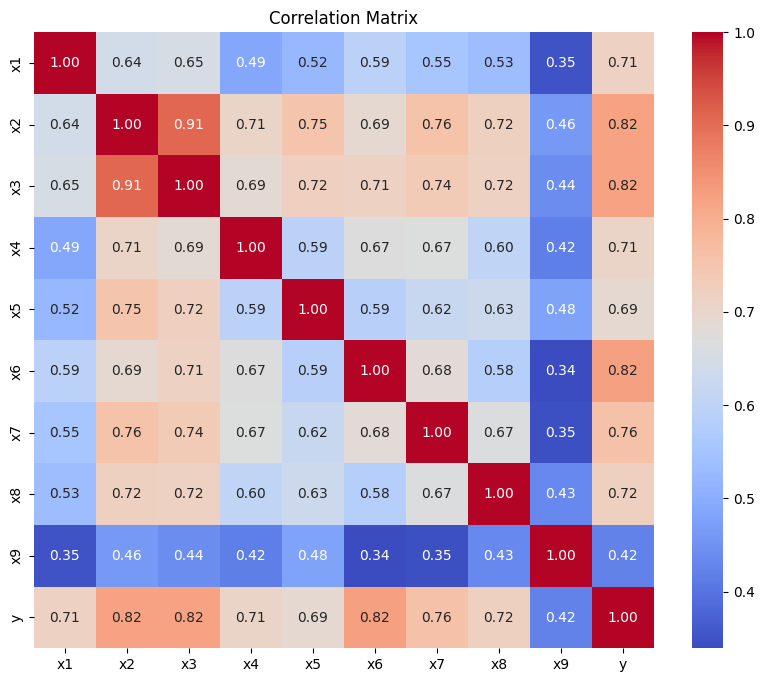

In [4]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Zorientowałem się, że korelacja Pearsona może dać nam jakieś głupie wnioski  
Użyjemy testu chisq

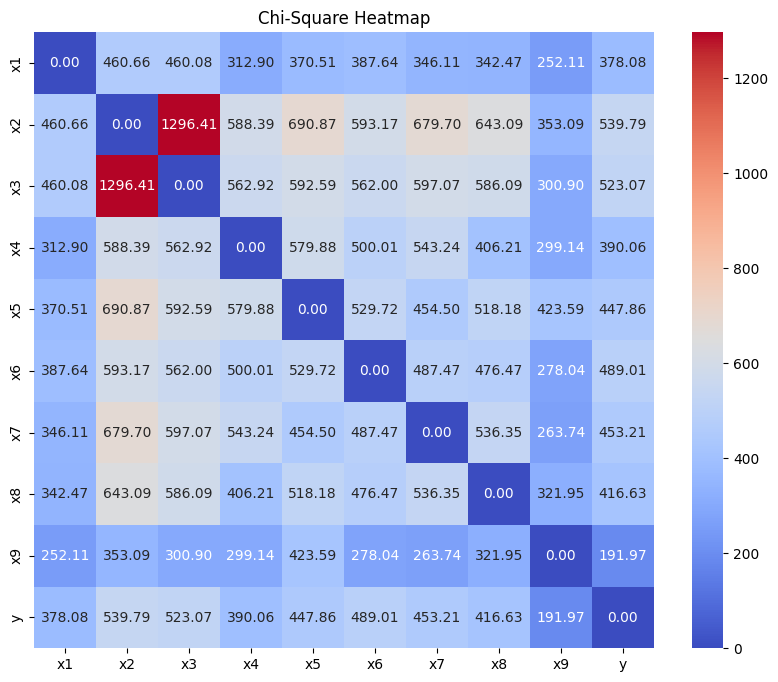

In [11]:
from utilz import chisq

chisq(df)

W sumie to wyniki się pokrywają  
x2 i x3 są silnie zależne, ciekawe co na to nasz naiwny Bayes  
Ale najpierw przegląd innych wykresów

<Figure size 1000x800 with 0 Axes>

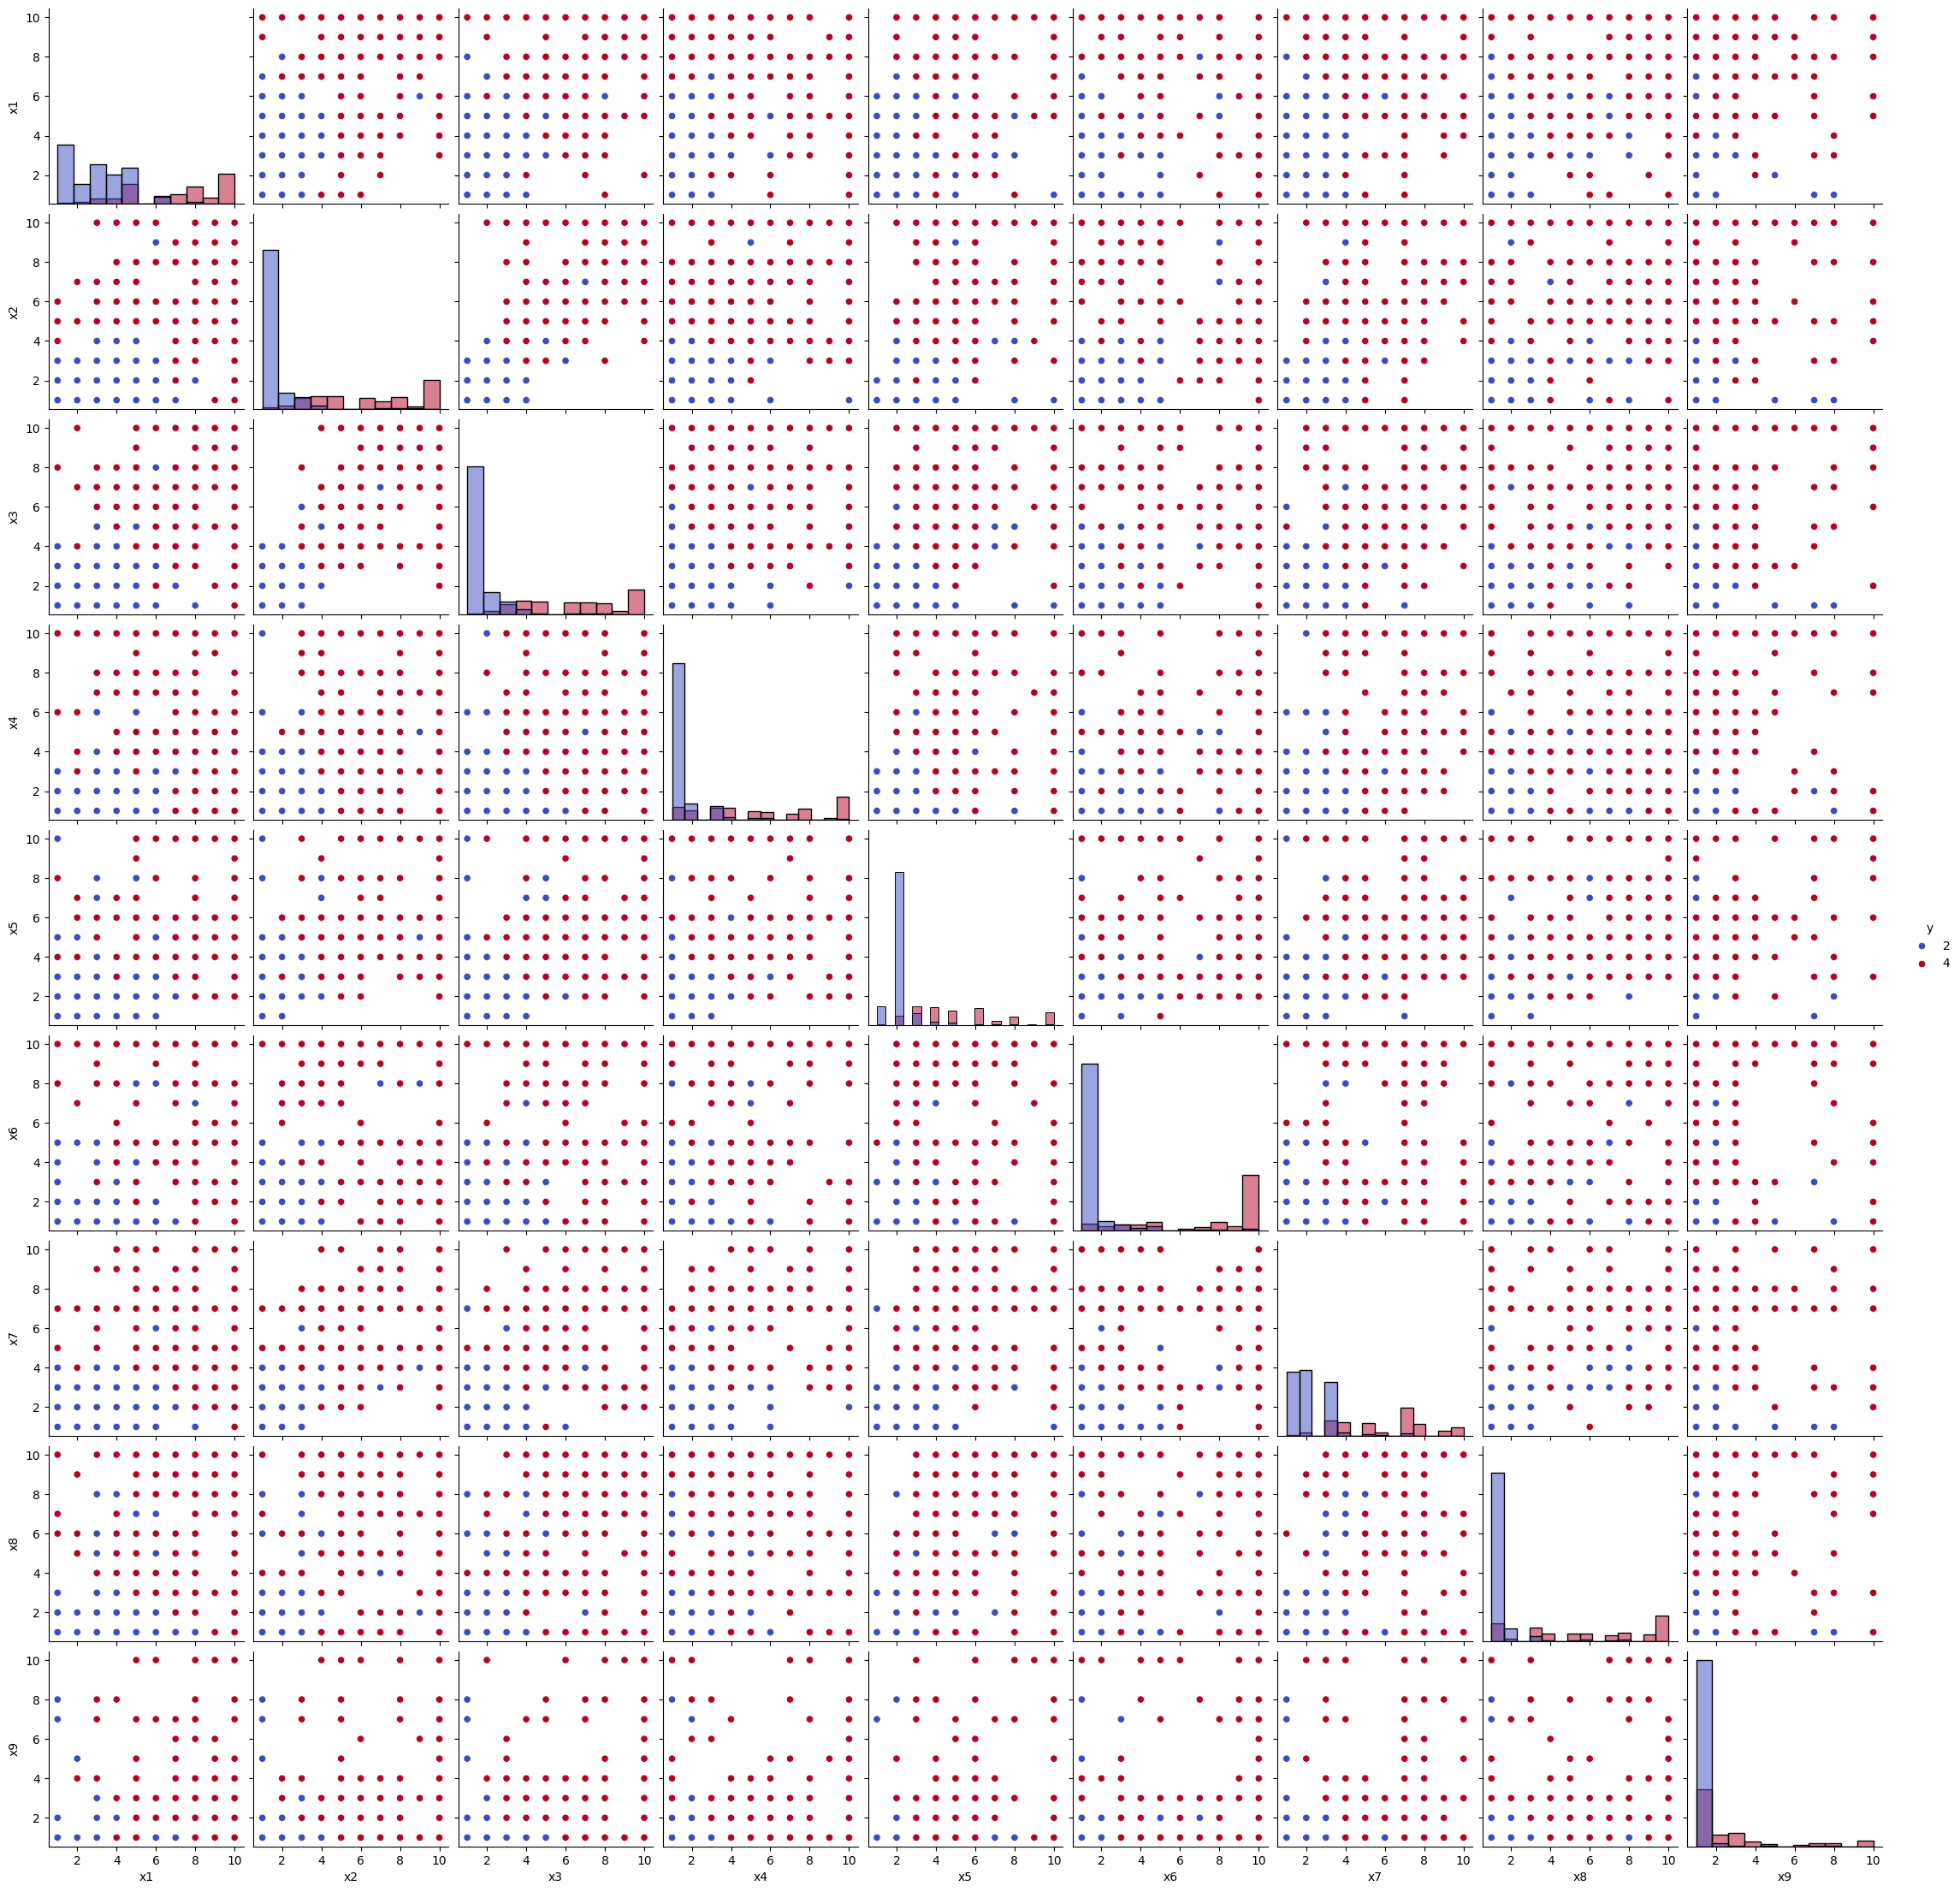

In [12]:
plt.figure(figsize=(10, 8))
sns.pairplot(df, hue='y', palette='coolwarm', diag_kind='hist')
plt.show()

Ten wykres jest dość duży, lepiej go oglądać jako zapisany obrazek.  
Z grubsza widzimy, że jeśli y = 2 to cechy < 5.  
Dodatkowo każda para jest na oko liniowo seperowalna.

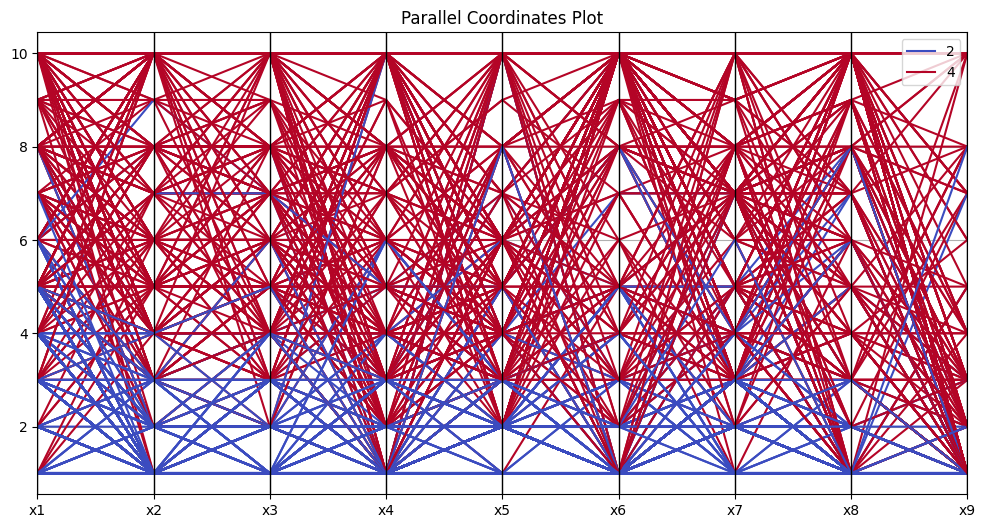

In [14]:
from pandas.plotting import parallel_coordinates

plt.figure(figsize=(12, 6))
parallel_coordinates(df, class_column='y', colormap='coolwarm')
plt.title('Parallel Coordinates Plot')
plt.show()

Potwierdza, się to co zauważyliśmy wcześniej.

In [16]:
from utilz import divide_dataset

T = 10 # numer of iterations
R = 7 # chosen iteration

datasets = []
for i in range(T):
    datasets.append(
        divide_dataset(
            XY.copy(),
            fractions_train_val_test=[0.67, 0.0, 0.33]))

Sanity check, czy klasy są równo rozłożone

In [17]:
from collections import Counter

U, _, V = datasets[R]

xy_c = Counter(XY[:, -1])
u_c = Counter(U[:, -1])
v_c = Counter(V[:, -1])

print(f'Class 2 ratio in train set: {u_c[2] / xy_c[2]:.2f}')
print(f'Class 4 ratio in train set: {u_c[4] / xy_c[4]:.2f}')
print(f'Class 2 ratio in test set: {v_c[2] / xy_c[2]:.2f}')
print(f'Class 4 ratio in test set: {v_c[4] / xy_c[4]:.2f}')


Class 2 ratio in train set: 0.67
Class 4 ratio in train set: 0.67
Class 2 ratio in test set: 0.33
Class 4 ratio in test set: 0.33


Zaczynamy od naiwnego Bayesa.  
Teraz nie wpadnę już w klątwę parametryzacji wielkiej funkcji :)

In [18]:
from classification import NaiveBayes
from measures import average_error

bayes = NaiveBayes()
bayes_average_error, bayes_average_training_error = average_error(bayes, datasets)

print(f'Naive Bayes average error: {bayes_average_error:.4f}')
print(f'Naive Bayes average training error: {bayes_average_training_error:.4f}')


Naive Bayes average error: 0.0274
Naive Bayes average training error: 0.0214


Sprawdźmy ze SciKitem

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import zero_one_loss
from utilz import split_data

train_r, _, test_r = datasets[R]
X_train_r, y_train_r = split_data(train_r)
X_test_r, y_test_r = split_data(test_r)

sklearn_bayes = MultinomialNB(alpha=1.0, fit_prior=True)
sklearn_bayes.fit(X_train_r, y_train_r.ravel())
sklearn_bayes_error = zero_one_loss(y_test_r.ravel(), sklearn_bayes.predict(X_test_r))
sklearn_bayes_training_error = zero_one_loss(y_train_r.ravel(), sklearn_bayes.predict(X_train_r))
print(f'Sklearn Naive Bayes error: {sklearn_bayes_error:.4f}')
print(f'Sklearn Naive Bayes training error: {sklearn_bayes_training_error:.4f}')

Sklearn Naive Bayes error: 0.0796
Sklearn Naive Bayes training error: 0.1028


In [20]:
from classification import NaiveBayes

train_r, _, test_r = datasets[R]
X_train_r, y_train_r = split_data(train_r)
X_test_r, y_test_r = split_data(test_r)

bayes = NaiveBayes()
bayes.fit(X_train_r, y_train_r)
bayes_error = bayes.zero_one_error(X_test_r, y_test_r)
bayes_training_error = bayes.zero_one_error(X_train_r, y_train_r)
print(f'Naive Bayes error: {bayes_error:.4f}')
print(f'Naive Bayes training error: {bayes_training_error:.4f}')


Naive Bayes error: 0.0265
Naive Bayes training error: 0.0219


Co tu się dzieje, czemu mój Bayes jest lepszy???  
Być może ja posiadam wiem więcej o danych niż SciKit.

In [21]:
print(f'Class probabilities sklearn: {np.exp(sklearn_bayes.class_log_prior_)}')
print(f'Class probabilities Naive Bayes: {bayes.class_mle}')

Class probabilities sklearn: [0.64989059 0.35010941]
Class probabilities Naive Bayes: [0.64923747 0.35076253]


Hmm... klasy działają, zobaczmy cechy

In [22]:
print(f'Feature probabilities sklearn:\n{np.exp(sklearn_bayes.feature_log_prob_)}')
print()
print(f'Feature probabilities Naive Bayes:\n{bayes.feature_mle}')

Feature probabilities sklearn:
[[0.19767442 0.08869129 0.09142727 0.09325125 0.14181487 0.09005928
  0.14113087 0.08458732 0.07136343]
 [0.13305834 0.12516205 0.12374779 0.10630524 0.10135533 0.14319387
  0.11255156 0.1053624  0.04926341]]

Feature probabilities Naive Bayes:
[array([[0.31270358, 0.10749186, 0.20521173, 0.13680782, 0.17263844,
        0.03908795, 0.00651466, 0.01302932, 0.00325733, 0.00325733],
       [0.81433225, 0.08143322, 0.05863192, 0.01628664, 0.00325733,
        0.00325733, 0.00651466, 0.00651466, 0.00651466, 0.00325733],
       [0.78501629, 0.10749186, 0.05537459, 0.01954397, 0.00325733,
        0.00651466, 0.00977199, 0.00651466, 0.00325733, 0.00325733],
       [0.79478827, 0.08143322, 0.06514658, 0.01302932, 0.01628664,
        0.01302932, 0.00325733, 0.00325733, 0.00325733, 0.00651466],
       [0.09771987, 0.7752443 , 0.06514658, 0.0228013 , 0.01628664,
        0.00325733, 0.00651466, 0.00325733, 0.00325733, 0.00651466],
       [0.85993485, 0.04234528, 0.0325

Chyba rozumiem, SciKit zakłada, że jest 9 cech 0-1, a w rzeczywistości jest 9 cech {1..10}.  
Jak już rozumiemy, że założenia o rozkładzie są bardzo ważne to popatrzmy jak szybko się to uczy.  
Czasowo i asymptotycznie ;)

In [25]:
from classification import NaiveBayes
from measures import average_fit_time

bayes = NaiveBayes()
bayes_average_fit_time = average_fit_time(bayes, datasets)
print(f'Naive Bayes average fit time: {bayes_average_fit_time:.7f} seconds')

Naive Bayes average fit time: 0.0005753 seconds


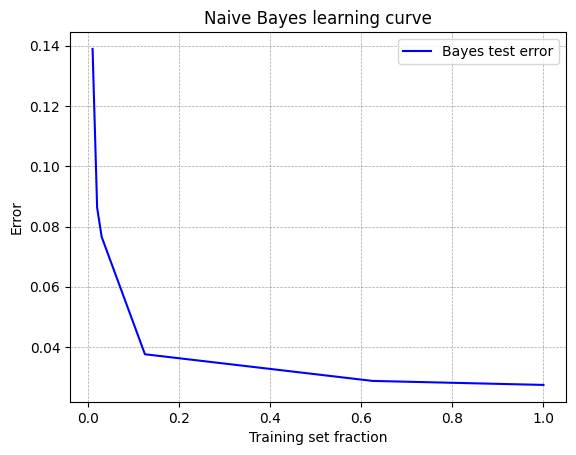

In [29]:
from classification import NaiveBayes
from measures import learning_curve

training_set_fractions = [0.01, 0.02, 0.03, 0.125, 0.625, 1]

bayes = NaiveBayes()
bayes_test_errors = learning_curve(bayes, datasets, training_set_fractions)

fig, ax = plt.subplots()
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
sns.lineplot(
    x = training_set_fractions, y = bayes_test_errors,
    ax = ax, label='Bayes test error', color='blue')
ax.set(xlabel='Training set fraction', ylabel='Error')
ax.set_title('Naive Bayes learning curve')
plt.legend()

Teraz możemy coś sprawdzić z artykułem.  
? 0.12 * m ~ log(n) ?
? 55 ~ log(9) ?  
Coś się nie chce zgodzić :(  
Pewnie przez stałe

Ok, spójrzmy sobie na dokładność, precyzję i czułość

In [30]:
from classification import NaiveBayes
from measures import average_acc_prec_sens

bayes = NaiveBayes()
bayes.fit(X_train_r, y_train_r)
bayes_accuracy, bayes_precision, bayes_sensitivity = average_acc_prec_sens(bayes, datasets)
print(f'Naive Bayes average accuracy: {bayes_accuracy:.4f}')
print(f'Naive Bayes average precision: {bayes_precision:.4f}')
print(f'Naive Bayes average sensitivity: {bayes_sensitivity:.4f}')


Naive Bayes average accuracy: 0.9726
Naive Bayes average precision: 0.9413
Naive Bayes average sensitivity: 0.9835


Nie ma co robić :)  
Z racji tego, że to jest rak, zależałoby nam na wysokiej czułości  
No i ją mamy  
Ale pobawmy się granicą decyzyjną, może wyciągniemy coś lepszego z tego Bayesa

In [31]:
from classification import NaiveBayes
from measures import average_acc_prec_sens

bayes = NaiveBayes(boundary=0.2)
bayes.fit(X_train_r, y_train_r)
bayes_accuracy, bayes_precision, bayes_sensitivity = average_acc_prec_sens(bayes, datasets)
print(f'Naive Bayes average accuracy: {bayes_accuracy:.4f}')
print(f'Naive Bayes average precision: {bayes_precision:.4f}')
print(f'Naive Bayes average sensitivity: {bayes_sensitivity:.4f}')


Naive Bayes average accuracy: 0.9739
Naive Bayes average precision: 0.9394
Naive Bayes average sensitivity: 0.9899


Rzeczywiście jesteśmy w stanie zmienić czułość granicą decyzyjną  
Ten bayes bardzo dobrze rozróżnia  
Poniżej prawdopodobieństwa a posteriori (dla któregoś z tych datasetów)  
```
0.0002501727910187334
0.9999955799911749
0.9999999999910805
0.999999999724131
3.95165834865358e-09
0.0002159627418231111
0.9999999988067703
3.95165834865358e-09
0.9999999995439866
1.7258835065009394e-08
```

Czas na regresję logistyczną.  
Wybrałem sobie wariant (jak się później okaże, porzucę ten pomysł):  
- intercept (bo czemu nie)
- standaryzacja
- zwykły GD (alpha = 0.1 z poprzedniego miniprojektu)
- L2

In [32]:
from classification import LogisticRegression
from gradient import GradientDescent

train_r, _, test_r = datasets[R]
X_train_r, y_train_r = split_data(train_r)
X_test_r, y_test_r = split_data(test_r)

regression = LogisticRegression(grad=GradientDescent(), standardize=False, alpha=0.01, epochs=500, fit_intercept=False)
regression.fit(X_train_r, y_train_r)
print(f'Logistic regression binary cross entropy test: {regression.binary_cross_entropy(X_test_r, y_test_r):.4f}')
print(f'Logistic regression binary cross entropy train: {regression.binary_cross_entropy(X_train_r, y_train_r):.4f}')


Logistic regression binary cross entropy test: 0.3863
Logistic regression binary cross entropy train: 0.4197


Szybki sanity check z SciKitem

In [33]:
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.metrics import log_loss

model = SklearnLogisticRegression(penalty=None, fit_intercept=False)
model.fit(X_train_r, y_train_r.ravel())
sk_log_loss = log_loss(y_test_r.ravel(), model.predict_proba(X_test_r))
print(f'Sklearn logistic regression binary cross entropy test: {sk_log_loss:.4f}')

sk_train_log_loss = log_loss(y_train_r.ravel(), model.predict_proba(X_train_r))
print(f'Sklearn logistic regression binary cross entropy train: {sk_train_log_loss:.4f}')

Sklearn logistic regression binary cross entropy test: 0.3486
Sklearn logistic regression binary cross entropy train: 0.4036


In [34]:
print(f'Sklearn logistic regression coefficients:\n{model.coef_.ravel()}')
print(f'Sklearn logistic regression intercept: {model.intercept_}')
print(f'Logistic regression coefficients:\n{regression.theta.ravel()}')
print(f'Logistic regression intercept: {regression.intercept}')

Sklearn logistic regression coefficients:
[-0.33063883  0.74300132  0.3396533   0.13640939 -0.71083237  0.52617665
 -0.50277816  0.20782285 -0.16836458]
Sklearn logistic regression intercept: [0.]
Logistic regression coefficients:
[-0.2931553   0.38698415  0.31174142  0.0932826  -0.41203587  0.39193158
 -0.32244666  0.15327112 -0.13478087]
Logistic regression intercept: 0


In [38]:
print(f'Logistic regression error: {regression.zero_one_error(X_test_r, y_test_r):.4f}')
print(f'Logistic regression training error: {regression.zero_one_error(X_train_r, y_train_r):.4f}')

Logistic regression error: 0.1327
Logistic regression training error: 0.1291


In [39]:
print(f'Logistic regression accuracy: {regression.accuracy(X_test_r, y_test_r):.4f}')
print(f'Logistic regression precision: {regression.precision(X_test_r, y_test_r):.4f}')
print(f'Logistic regression sensitivity: {regression.sensitivity(X_test_r, y_test_r):.4f}')

Logistic regression accuracy: 0.8673
Logistic regression precision: 0.7579
Logistic regression sensitivity: 0.9114


In [40]:
print(f'SklearnLogisticRegression accuracy: {model.score(X_test_r, y_test_r.ravel()):.4f}')

SklearnLogisticRegression accuracy: 0.8717


Po długiej walce jest zadowalająco  
Wersja:
- bez intercept
- GD (alpha=0.01 epochs=500)
- bez L2
- bez standaryzacji  

Można powiedzieć, że działam tak samo jak Sklearn

In [41]:
from classification import LogisticRegression
from gradient import GradientDescentWithWeightedIntercept

train_r, _, test_r = datasets[R]
X_train_r, y_train_r = split_data(train_r)
X_test_r, y_test_r = split_data(test_r)

regression = LogisticRegression(grad=GradientDescentWithWeightedIntercept(), standardize=False, alpha=0.1, epochs=100, fit_intercept=True)
regression.fit(X_train_r, y_train_r)
print(
  f'Logistic regression binary cross entropy test: {regression.binary_cross_entropy(X_test_r, y_test_r):.4f}')
print(
  f'Logistic regression binary cross entropy train: {regression.binary_cross_entropy(X_train_r, y_train_r):.4f}')
print(f'Logistic regression error: {regression.zero_one_error(X_test_r, y_test_r):.4f}')
print(f'Logistic regression training error: {regression.zero_one_error(X_train_r, y_train_r):.4f}')
print(f'Logistic regression accuracy: {regression.accuracy(X_test_r, y_test_r):.4f}')
print(f'Logistic regression precision: {regression.precision(X_test_r, y_test_r):.4f}')
print(f'Logistic regression sensitivity: {regression.sensitivity(X_test_r, y_test_r):.4f}')

Logistic regression binary cross entropy test: 0.0531
Logistic regression binary cross entropy train: 0.0924
Logistic regression error: 0.0265
Logistic regression training error: 0.0306
Logistic regression accuracy: 0.9735
Logistic regression precision: 0.9506
Logistic regression sensitivity: 0.9747


In [42]:
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.metrics import log_loss

model = SklearnLogisticRegression(penalty=None, fit_intercept=True)
model.fit(X_train_r, y_train_r.ravel())
sk_log_loss = log_loss(y_test_r.ravel(), model.predict_proba(X_test_r))
sk_train_log_loss = log_loss(y_train_r.ravel(), model.predict_proba(X_train_r))
print(f'Sklearn logistic regression binary cross entropy test: {sk_log_loss:.4f}')
print(f'Sklearn logistic regression binary cross entropy train: {sk_train_log_loss:.4f}')
print(f'SklearnLogisticRegression accuracy: {model.score(X_test_r, y_test_r.ravel()):.4f}')

Sklearn logistic regression binary cross entropy test: 0.0689
Sklearn logistic regression binary cross entropy train: 0.0860
SklearnLogisticRegression accuracy: 0.9646


In [43]:
print(f'Sklearn logistic regression coefficients:\n{model.coef_.ravel()}')
print(f'Sklearn logistic regression intercept: {model.intercept_}')
print(f'Logistic regression coefficients:\n{regression.theta.ravel()}')
print(f'Logistic regression intercept: {regression.intercept}')

Sklearn logistic regression coefficients:
[ 0.4877282  -0.24533598  0.4290527   0.21930881  0.32897178  0.30763293
  0.53630574  0.26826829  0.54242382]
Sklearn logistic regression intercept: [-9.93072206]
Logistic regression coefficients:
[0.42993176 0.21213804 0.30994578 0.23260064 0.20243929 0.34207709
 0.33892105 0.27464691 0.23463487]
Logistic regression intercept: -9.382312273351634


Wersja:  
- intercept
- GD (alpha=0.1, epochs=100)
- bez L2
- bez standaryzacji  

Jest podejrzenie, że gradient nierówno schodzi  
i po usunięciu 1/m z interceptu jest OK  
Co ma dużo sensu, cały czas nie możemy się wbić w minimum  

Poniżej znormalizowany gradient, który daje pole interceptowi

In [44]:
from classification import LogisticRegression
from gradient import NormalizedGradientDescent

train_r, _, test_r = datasets[R]
X_train_r, y_train_r = split_data(train_r)
X_test_r, y_test_r = split_data(test_r)

regression = LogisticRegression(grad=NormalizedGradientDescent(), standardize=False, alpha=0.0001, epochs=500, fit_intercept=True)
regression.fit(X_train_r, y_train_r)
print(
  f'Logistic regression binary cross entropy test: {regression.binary_cross_entropy(X_test_r, y_test_r):.4f}')
print(
  f'Logistic regression binary cross entropy train: {regression.binary_cross_entropy(X_train_r, y_train_r):.4f}')
print(f'Logistic regression error: {regression.zero_one_error(X_test_r, y_test_r):.4f}')
print(f'Logistic regression training error: {regression.zero_one_error(X_train_r, y_train_r):.4f}')
print(f'Logistic regression accuracy: {regression.accuracy(X_test_r, y_test_r):.4f}')
print(f'Logistic regression precision: {regression.precision(X_test_r, y_test_r):.4f}')
print(f'Logistic regression sensitivity: {regression.sensitivity(X_test_r, y_test_r):.4f}')

Logistic regression binary cross entropy test: 0.0657
Logistic regression binary cross entropy train: 0.1035
Logistic regression error: 0.0310
Logistic regression training error: 0.0350
Logistic regression accuracy: 0.9690
Logistic regression precision: 0.9500
Logistic regression sensitivity: 0.9620


Jeszcze sprawdzę czy standaryzacja działa

In [46]:
from classification import LogisticRegression
from gradient import NormalizedGradientDescent

train_r, _, test_r = datasets[R]
X_train_r, y_train_r = split_data(train_r)
X_test_r, y_test_r = split_data(test_r)

regression = LogisticRegression(grad=NormalizedGradientDescent(), standardize=True, alpha=0.01, epochs=10, fit_intercept=True)
regression.fit(X_train_r, y_train_r)

print(
  f'Logistic regression binary cross entropy test: {regression.binary_cross_entropy(X_test_r, y_test_r):.4f}')
print(
  f'Logistic regression binary cross entropy train: {regression.binary_cross_entropy(X_train_r, y_train_r):.4f}')
print(f'Logistic regression error: {regression.zero_one_error(X_test_r, y_test_r):.4f}')
print(f'Logistic regression training error: {regression.zero_one_error(X_train_r, y_train_r):.4f}')
print(f'Logistic regression accuracy: {regression.accuracy(X_test_r, y_test_r):.4f}')
print(f'Logistic regression precision: {regression.precision(X_test_r, y_test_r):.4f}')
print(f'Logistic regression sensitivity: {regression.sensitivity(X_test_r, y_test_r):.4f}')

Logistic regression binary cross entropy test: 0.0691
Logistic regression binary cross entropy train: 0.0931
Logistic regression error: 0.0265
Logistic regression training error: 0.0350
Logistic regression accuracy: 0.9735
Logistic regression precision: 0.9620
Logistic regression sensitivity: 0.9620


Niesamowite, to mnie nie przestanie zaskakiwać, jak skalowanie przyspiesza zbieżność  
Odpuszczam już sobie L2, bo jest naprawdę dobrze  
Zostajemy z wersją:
- intercept
- standaryzacja
- normalizowany gradient (alpha=0.01, epochs=10)
- bez L2

To teraz czas na uśrednienie wyników

In [47]:
from classification import LogisticRegression
from gradient import NormalizedGradientDescent
from measures import average_error

regression = LogisticRegression(
  grad=NormalizedGradientDescent(),
  standardize=True,
  alpha=0.01,
  epochs=10,
  fit_intercept=True)

regression_average_error, regression_average_training_error = average_error(regression, datasets)

print(f'Logistic regression average error: {regression_average_error:.4f}')
print(f'Logistic regression average training error: {regression_average_training_error:.4f}')

Logistic regression average error: 0.0385
Logistic regression average training error: 0.0298


In [48]:
from measures import average_acc_prec_sens

regression_average_acc, regression_average_prec, regression_average_sens = average_acc_prec_sens(regression, datasets)
print(f'Logistic regression average accuracy: {regression_average_acc:.4f}')
print(f'Logistic regression average precision: {regression_average_prec:.4f}')
print(f'Logistic regression average sensitivity: {regression_average_sens:.4f}')

Logistic regression average accuracy: 0.9615
Logistic regression average precision: 0.9551
Logistic regression average sensitivity: 0.9342


Tu pewnie też moglibyśmy przesunać granicę decyzyjną

In [49]:
from measures import average_fit_time

regression_average_fit_time = average_fit_time(regression, datasets)
print(f'Logistic regression average fit time: {regression_average_fit_time:.7f} seconds')

Logistic regression average fit time: 0.0016249 seconds


Bayes jest szybszy, co było oczekiwane

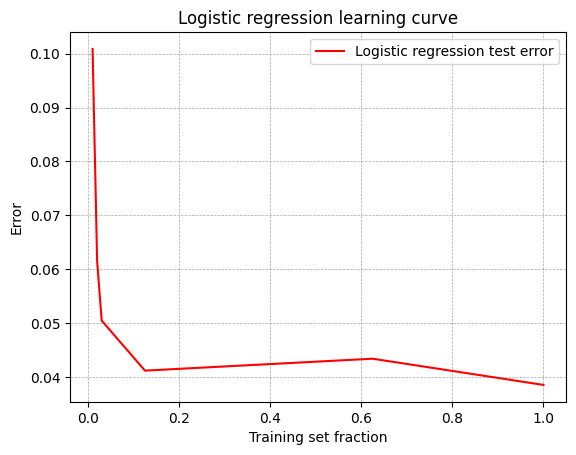

In [50]:
from classification import LogisticRegression
from gradient import NormalizedGradientDescent
from measures import learning_curve

training_set_fractions = [0.01, 0.02, 0.03, 0.125, 0.625, 1]

regression = LogisticRegression(
  grad=NormalizedGradientDescent(),
  standardize=True,
  alpha=0.01,
  epochs=10,
  fit_intercept=True)

regression_test_errors = learning_curve(regression, datasets, training_set_fractions)

fig, ax = plt.subplots()
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
sns.lineplot(
    x = training_set_fractions, y = regression_test_errors,
    ax = ax, label='Logistic regression test error', color='red')
ax.set(xlabel='Training set fraction', ylabel='Error')
ax.set_title('Logistic regression learning curve')
plt.legend()

Tu był malutki problem, czasami wychodziło std = 0, teraz jesi zclipowane

Czas na wielkie porównanie

In [51]:
print(f'Logistic regression average error: {regression_average_error:.4f}')
print(f'Naive Bayes average error: {bayes_average_error:.4f}')
print()
print(f'Logistic regression average accuracy: {regression_average_acc:.4f}')
print(f'Naive Bayes average accuracy: {bayes_accuracy:.4f}')
print()
print(f'Logistic regression average precision: {regression_average_prec:.4f}')
print(f'Naive Bayes average precision: {bayes_precision:.4f}')
print()
print(f'Logistic regression average sensitivity: {regression_average_sens:.4f}')
print(f'Naive Bayes average sensitivity: {bayes_sensitivity:.4f}')
print()
print(f'Logistic regression average fit time: {regression_average_fit_time:.7f} seconds')
print(f'Naive Bayes average fit time: {bayes_average_fit_time:.7f} seconds')

Logistic regression average error: 0.0385
Naive Bayes average error: 0.0274

Logistic regression average accuracy: 0.9615
Naive Bayes average accuracy: 0.9739

Logistic regression average precision: 0.9551
Naive Bayes average precision: 0.9394

Logistic regression average sensitivity: 0.9342
Naive Bayes average sensitivity: 0.9899

Logistic regression average fit time: 0.0016249 seconds
Naive Bayes average fit time: 0.0005753 seconds


Wychodzi nam, że Bayes jest lepszy co było nieoczekiwane

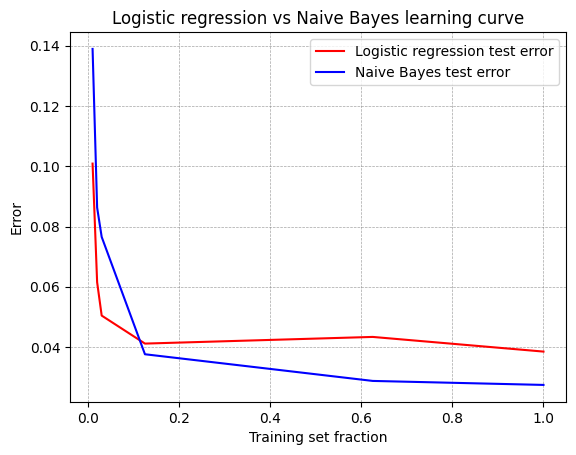

In [52]:
fig, ax = plt.subplots()
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
sns.lineplot(
    x = training_set_fractions, y = regression_test_errors,
    ax = ax, label='Logistic regression test error', color='red')
sns.lineplot(
    x = training_set_fractions, y = bayes_test_errors,
    ax = ax, label='Naive Bayes test error', color='blue')

ax.set(xlabel='Training set fraction', ylabel='Error')
ax.set_title('Logistic regression vs Naive Bayes learning curve')
plt.legend()

Być może nawet to się zgadza z artykułem, bo regresja chce jeszcze iść, ale moje umiejętności hiperparametryzowania jej na to nie pozwalają.

BONUS wykresy czułości i precyzji

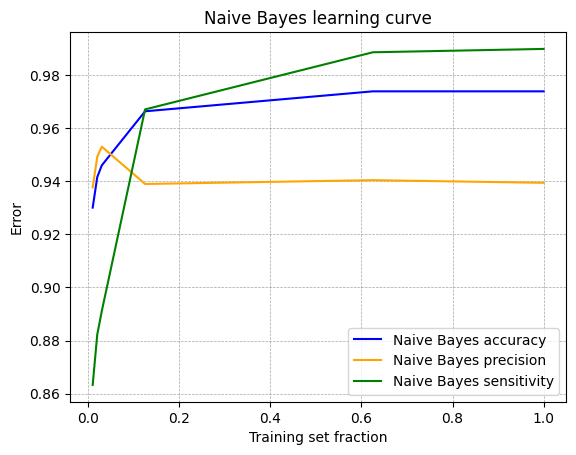

In [53]:
from classification import NaiveBayes
from measures import learning_curve_acc_prec_sens

training_set_fractions = [0.01, 0.02, 0.03, 0.125, 0.625, 1]
bayes = NaiveBayes(boundary=0.2)
bayes_learning_curve = learning_curve_acc_prec_sens(bayes, datasets, training_set_fractions)

fig, ax = plt.subplots()
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
sns.lineplot(
    x = training_set_fractions, y = bayes_learning_curve[0],
    ax = ax, label='Naive Bayes accuracy', color='blue')
sns.lineplot(
    x = training_set_fractions, y = bayes_learning_curve[1],
    ax = ax, label='Naive Bayes precision', color='orange')
sns.lineplot(
    x = training_set_fractions, y = bayes_learning_curve[2],
    ax = ax, label='Naive Bayes sensitivity', color='green')
ax.set(xlabel='Training set fraction', ylabel='Error')
ax.set_title('Naive Bayes learning curve')
plt.legend()

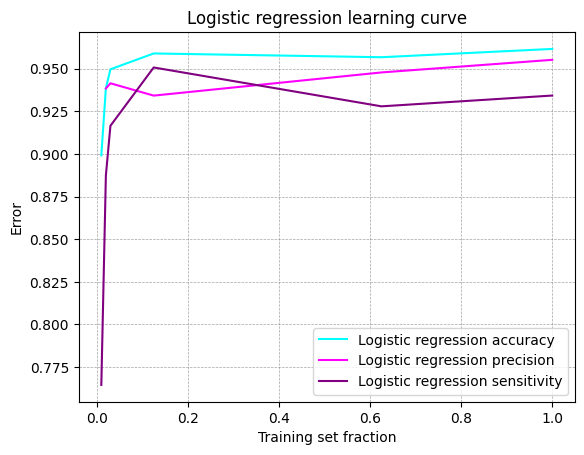

In [54]:
from classification import LogisticRegression
from gradient import NormalizedGradientDescent
from measures import learning_curve_acc_prec_sens

training_set_fractions = [0.01, 0.02, 0.03, 0.125, 0.625, 1]
regression = LogisticRegression(
  grad=NormalizedGradientDescent(),
  standardize=True,
  alpha=0.01,
  epochs=10,
  fit_intercept=True)

regression_learning_curve = learning_curve_acc_prec_sens(regression, datasets, training_set_fractions)

fig, ax = plt.subplots()
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
sns.lineplot(
    x = training_set_fractions, y = regression_learning_curve[0],
    ax = ax, label='Logistic regression accuracy', color='cyan')
sns.lineplot(
    x = training_set_fractions, y = regression_learning_curve[1],
    ax = ax, label='Logistic regression precision', color='magenta')
sns.lineplot(
    x = training_set_fractions, y = regression_learning_curve[2],
    ax = ax, label='Logistic regression sensitivity', color='purple')
ax.set(xlabel='Training set fraction', ylabel='Error')
ax.set_title('Logistic regression learning curve')
plt.legend()


Jeszcze je nałożymy, żeby było co pokazywać

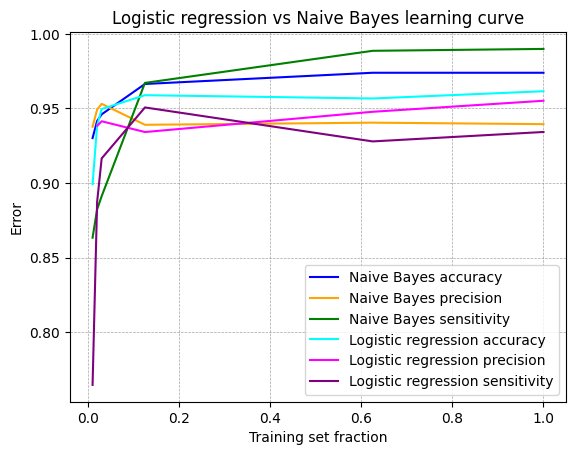

In [55]:
fig, ax = plt.subplots()
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
sns.lineplot(
    x = training_set_fractions, y = bayes_learning_curve[0],
    ax = ax, label='Naive Bayes accuracy', color='blue')
sns.lineplot(
    x = training_set_fractions, y = bayes_learning_curve[1],
    ax = ax, label='Naive Bayes precision', color='orange')
sns.lineplot(
    x = training_set_fractions, y = bayes_learning_curve[2],
    ax = ax, label='Naive Bayes sensitivity', color='green')
sns.lineplot(
    x = training_set_fractions, y = regression_learning_curve[0],
    ax = ax, label='Logistic regression accuracy', color='cyan')
sns.lineplot(
    x = training_set_fractions, y = regression_learning_curve[1],
    ax = ax, label='Logistic regression precision', color='magenta')
sns.lineplot(
    x = training_set_fractions, y = regression_learning_curve[2],
    ax = ax, label='Logistic regression sensitivity', color='purple')
ax.set(xlabel='Training set fraction', ylabel='Error')
ax.set_title('Logistic regression vs Naive Bayes learning curve')
plt.legend()

Co jest ciekawe, one wszystkie stabilizują się mniej więcej w tym samym pukcie  

THE END